![](img/330-banner.png)

# Lecture 12: Feature importances

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("code/.")

from plotting_functions import *
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from utils import *

import seaborn as sns

## Learning outcomes 

From this lecture, students are expected to be able to:

- Interpret the coefficients of linear regression for ordinal, one-hot encoded categorical, and scaled numeric features. 
- Explain why interpretability is important in ML.
- Use `feature_importances_` attribute of `sklearn` models and interpret its output. 
- Use `eli5` to get feature importances of non `sklearn` models and interpret its output. 
- Apply SHAP to assess feature importances and interpret model predictions. 
- Explain force plot, summary plot, and dependence plot produced with shapely values.  

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## Data 

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/), the dataset we used in lecture 2. As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data`. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [3]:
df = pd.read_csv("data/housing-kaggle/train.csv")
train_df, test_df = train_test_split(df, test_size = 0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The prediction task is predicting `SalePrice` given features related to properties.  
- Note that the target is numeric, not categorical.

In [4]:
train_df.shape

(1314, 81)

### Let's separate `X` and `y`

In [5]:
X_train = train_df.drop(columns=['SalePrice'])
y_train = train_df['SalePrice']

X_test = test_df.drop(columns=['SalePrice'])
y_test = test_df['SalePrice']

### Let's identify feature types

In [6]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr",
    "KitchenAbvGr", 
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "YrSold",
]

In [7]:
ordinal_features_reg = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
    "PoolQC",
]
ordering = [
    "Po",
    "Fa",
    "TA",
    "Gd",
    "Ex",
]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

In [8]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],    
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

In [9]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)    
    - set(drop_features)
)
categorical_features

['SaleCondition',
 'Exterior1st',
 'Street',
 'CentralAir',
 'MSZoning',
 'PavedDrive',
 'Utilities',
 'Foundation',
 'RoofMatl',
 'Condition2',
 'Neighborhood',
 'LandContour',
 'Exterior2nd',
 'Electrical',
 'Alley',
 'MSSubClass',
 'MoSold',
 'MiscFeature',
 'SaleType',
 'GarageType',
 'RoofStyle',
 'Heating',
 'LotShape',
 'Condition1',
 'MasVnrType',
 'HouseStyle',
 'GarageFinish',
 'LandSlope',
 'LotConfig',
 'BldgType']

In [10]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg),
)

ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth),
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),    
    (categorical_transformer, categorical_features),
)

In [11]:
preprocessor.fit(X_train)
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [12]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

In [13]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,1.372763,-0.222647,-0.025381,-0.127107,-0.054669,2.184405,-0.165485,0.743555,0.843281,-0.090231,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1122,0.154795,-0.222647,-0.025381,-0.149788,-1.491366,-2.310284,-0.496757,-1.389065,-0.573129,-0.961498,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1346,0.154795,-0.222647,-0.025381,1.168244,0.663680,1.285467,-0.099230,0.888961,-0.573129,-0.314582,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1406,-1.063173,-0.222647,0.022331,-0.203265,-0.773017,1.285467,0.033279,1.082835,-0.573129,0.467379,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [14]:
X_train_enc.shape

(1314, 263)

### Feature correlations

- Let's look at the correlations between various features with other features and the target in our encoded data (first row/column). 
- In simple terms here is how you can interpret correlations between two variables $X$ and $Y$:
  - If $Y$ goes up when $X$ goes up, we say $X$ and $Y$ are positively correlated.
  - If $Y$ goes down when $X$ goes up, we say $X$ and $Y$ are negatively correlated.
  - If $Y$ is unchanged when $X$ changes, we say $X$ and $Y$ are uncorrelated.

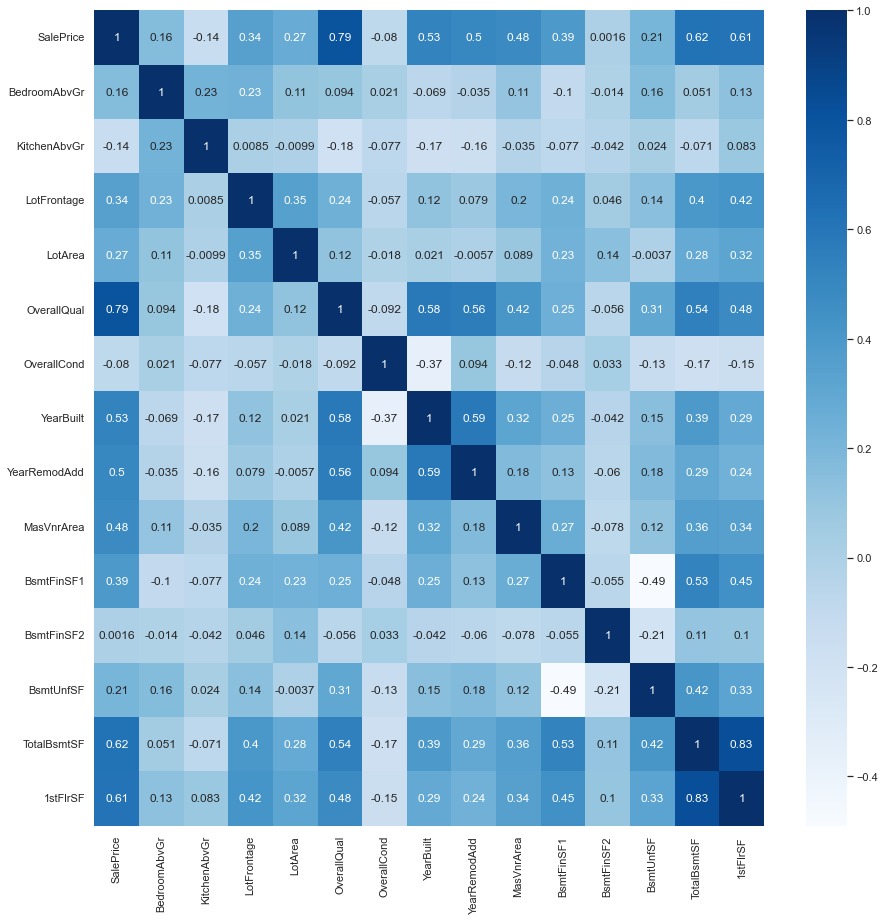

In [15]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,:15].corr();
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- We can immediately see that `SalePrice` is highly correlated with `OverallQual`.
- This is an early hint that `OverallQual` is a useful feature in predicting `SalePrice`.
- However, this approach is **extremely simplistic**.
  - It only looks at each feature in isolation.
  - It only looks at linear associations:
    - What if `SalePrice` is high when `BsmtFullBath` is 2 or 3, but low when it's 0, 1, or 4? They might seem uncorrelated.

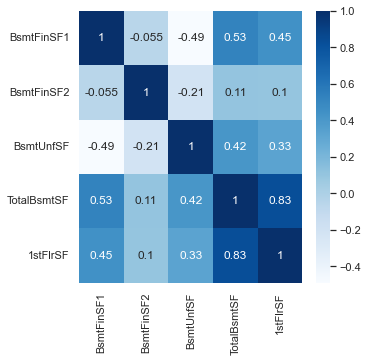

In [16]:
cor = pd.concat((y_train, X_train_enc),axis=1).iloc[:,10:15].corr();
plt.figure(figsize=(5,5))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

- Looking at this diagram also tells us the relationship between features. 
  - For example, `1stFlrSF` and `TotalBsmtSF` are highly correlated. 
  - Do we need both of them?
  - If our model says `1stFlrSF` is very important and `TotalBsmtSF` is very unimportant, do we trust those values?
  - Maybe `TotalBsmtSF` only "becomes important" if `1stFlrSF` is removed.
  - Sometimes the opposite happens: a feature only becomes important if another feature is _added_.

<br><br><br><br>

## Feature importances in linear models 

- Like logistic regression, with linear regression we can look at the _coefficients_ for each feature.
- Overall idea: predicted price = intercept + $\sum_i$ coefficient i $\times$ feature i.

In [17]:
lr = make_pipeline(preprocessor, Ridge())
lr.fit(X_train, y_train);

Let's look at the coefficients. 

In [18]:
lr_coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns, columns=["Coefficient"])
lr_coefs.head(20)

,Coefficient
BedroomAbvGr,-3723.741570
KitchenAbvGr,-4580.204576
LotFrontage,-1578.664421
LotArea,5109.356718
OverallQual,12487.561839
OverallCond,4855.535334
YearBuilt,4226.684842
YearRemodAdd,324.664715
MasVnrArea,5251.325210
BsmtFinSF1,3667.172851


### Interpreting coefficients of different types of features. 

### Ordinal features

- The ordinal features are easiest to interpret. 

In [19]:
print(ordinal_features_reg)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


In [20]:
lr_coefs.loc["ExterQual", 'Coefficient']

4195.671512467538

- "Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$3845".
  - Wow, that's a lot! 

In [21]:
one_example = X_test[:1]

In [22]:
one_example['ExterQual']

147    Gd
Name: ExterQual, dtype: object

Let's perturb the example and change `ExterQual` to `Ex`. 

In [23]:
one_example_perturbed = one_example.copy()
one_example_perturbed["ExterQual"] = 'Ex' # Change Gd to Ex

In [24]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


In [25]:
one_example_perturbed['ExterQual']

147    Ex
Name: ExterQual, dtype: object

How does the prediction change after changing `ExterQual` from `Gd` to `Ex`? 

In [26]:
print('Prediction on the original example: ', lr.predict(one_example))
print('Prediction on the perturbed example: ', lr.predict(one_example_perturbed))
print("After changing ExterQual from Gd to Ex increased the prediction by: ", lr.predict(one_example_perturbed) - lr.predict(one_example))

Prediction on the original example:  [224795.63596802]
Prediction on the perturbed example:  [228991.30748049]
After changing ExterQual from Gd to Ex increased the prediction by:  [4195.67151247]


That's exactly the learned coefficient for `ExterQual`! 

In [27]:
lr_coefs.loc["ExterQual", 'Coefficient']

4195.671512467538

So our interpretation is correct! 
- Increasing by one category of exterior quality (e.g. good -> excellent) increases the predicted price by \\$3845.

### Categorical features

- What about the categorical features?
- We have created a number of columns for each category with OHE and each category gets it's own coefficient. 

In [28]:
print(categorical_features)

['SaleCondition', 'Exterior1st', 'Street', 'CentralAir', 'MSZoning', 'PavedDrive', 'Utilities', 'Foundation', 'RoofMatl', 'Condition2', 'Neighborhood', 'LandContour', 'Exterior2nd', 'Electrical', 'Alley', 'MSSubClass', 'MoSold', 'MiscFeature', 'SaleType', 'GarageType', 'RoofStyle', 'Heating', 'LotShape', 'Condition1', 'MasVnrType', 'HouseStyle', 'GarageFinish', 'LandSlope', 'LotConfig', 'BldgType']


In [29]:
lr_coefs_landslope = lr_coefs[lr_coefs.index.str.startswith("LandSlope")]
lr_coefs_landslope

,Coefficient
LandSlope_Gtl,457.197456
LandSlope_Mod,7420.208381
LandSlope_Sev,-7877.405837


- We can talk about switching from one of these categories to another by picking a "reference" category:

In [30]:
lr_coefs_landslope - lr_coefs_landslope.loc["LandSlope_Gtl"]

,Coefficient
LandSlope_Gtl,0.000000
LandSlope_Mod,6963.010925
LandSlope_Sev,-8334.603292


- If you change the category from `LandSlope_Gtl` to `LandSlope_Mod` the prediction price goes up by $\sim\$7013$
- If you change the category from `LandSlope_Gtl` to `LandSlope_Sev` the prediction price goes down by $\sim\$8016$


Note that this might not make sense in the real world but this is what our model decided to learn given this small amount of data. 

```{note}
If you did `drop='first'` (we didn't) then you already have a reference class, and all the values are with respect to that one. The interpretation depends on whether we did `drop='first'`, hence the hassle.
```

### Interpreting coefficients of numeric features

Let's look at coefficients of `PoolArea` and `LotFrontage`. 

In [31]:
lr_coefs.loc[["PoolArea", "LotFrontage"]]

,Coefficient
PoolArea,2822.370476
LotFrontage,-1578.664421


Intuition: 

- **Increasing** `PoolArea` by 1 scaled unit **increases** the predicted price by $\sim\$3372$.
- **Increasing** `LotFrontage` by 1 scaled unit **decreases** the predicted price by $\sim\$1703$.

Does that sound reasonable?

- For `PoolArea`, yes. 
- For `LotFrontage`, that's surprising. Something positive would have made more sense?
- Do we believe these interpretations??
  - Do we believe this is how the predictions are being computed? Yes.
  - Do we believe that this is how the world works? No. 

It's not the case here but maybe the problem is that `LotFrontage` and `LotArea` are very correlated. `LotArea` has a larger positive coefficient. 

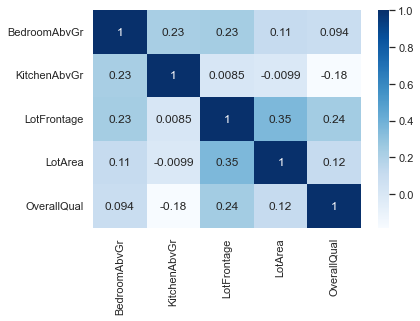

In [32]:
cor = X_train_enc[numeric_features[:5]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);

BTW, let's make sure the predictions behave as expected:

In [33]:
one_example = X_test[:1]

In [34]:
one_example

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9505,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Let's perturb the example and add 1 to the `LotArea`. 

In [35]:
one_example_perturbed = one_example.copy()
one_example_perturbed["LotArea"] += 1 # add 1 to the LotArea

In [36]:
one_example_perturbed

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
147,148,60,RL,NaN,9506,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal


Prediction on the original example. 

In [37]:
lr.predict(one_example)

array([224795.63596802])

Prediction on the perturbed example. 

In [38]:
lr.predict(one_example_perturbed)

array([224796.2040233])

- What's the difference between prediction? 
- Does the difference make sense given the coefficient of the feature? 

In [39]:
lr.predict(one_example_perturbed) - lr.predict(one_example)

array([0.56805528])

In [40]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- Why did the prediction only go up by \\$0.57 instead of \\$5109? 
- This is an issue of units. `LotArea` is in sqft, but the coefficient is not $\$5109/\text{sqft}$ **because we scaled the features**. 

### Example showing how can we interpret coefficients of scaled features. 

- The scaler subtracted the mean and divided by the standard deviation.
- The division actually changed the scale! 
- For the unit conversion, we don't care about the subtraction, but only the scaling.

In [41]:
scaler = preprocessor.named_transformers_['pipeline-1']['standardscaler']

In [42]:
np.sqrt(scaler.var_)

array([8.21039683e-01, 2.18760172e-01, 2.09591390e+01, 8.99447103e+03,
       1.39208177e+00, 1.11242416e+00, 3.01866337e+01, 2.06318985e+01,
       1.77914527e+02, 4.59101890e+02, 1.63890010e+02, 4.42869860e+02,
       4.42817167e+02, 3.92172897e+02, 4.35820743e+02, 4.69800920e+01,
       5.29468070e+02, 5.18276015e-01, 2.33809970e-01, 5.49298599e-01,
       5.02279069e-01, 1.62604030e+00, 6.34398801e-01, 2.40531598e+01,
       7.40269201e-01, 2.10560601e+02, 1.25388753e+02, 6.57325181e+01,
       6.07432962e+01, 3.03088902e+01, 5.38336322e+01, 4.23249944e+01,
       5.22084645e+02, 1.33231649e+00])

In [43]:
lr_scales = pd.DataFrame(data=np.sqrt(scaler.var_), index=numeric_features, columns=["Scale"])
lr_scales.head()

,Scale
BedroomAbvGr,0.821040
KitchenAbvGr,0.218760
LotFrontage,20.959139
LotArea,8994.471032
OverallQual,1.392082


In [44]:
lr_coefs.loc["LotArea","Coefficient"]

5109.356718094067

In [45]:
lr_scales.loc["LotArea","Scale"]

8994.47103226631

- It seems like `LotArea` was divided by 8994.471032 sqft. 

In [46]:
lr_coefs.loc["LotArea","Coefficient"]/lr_scales.loc["LotArea","Scale"]

0.5680552752646619

In [47]:
lr_coefs.loc[["LotArea"]]

,Coefficient
LotArea,5109.356718


- The coefficient tells us that if we increase the **scaled** `LotArea` by one unit the price would go up by $\approx\$5109$. 
- One scaled unit represents 8994 sq feet. 

- So if I increase original `LotArea` by one square foot then the predicted price would go up by this amount: 

In [69]:
5134.590415/8994.471032 

0.570860742864417

- This makes much more sense. Now we get the number we got before. 
- That said don't read too much into these coefficients without statistical training. 

### Interim summary

- Correlation among features might make coefficients completely uninterpretable. 
- Fairly straightforward to interpret coefficients of ordinal features. 
- In categorical features, it's often helpful to consider one category as a reference point and think about relative importance. 
- For numeric features, relative importance is meaningful after scaling.
- You have to be careful about the scale of the feature when interpreting the coefficients. 

We will talk about features importances beyond linear models later in the course. 

- Remember that explaining the model $\neq$ explaining the data.  
- the coefficients tell us only about the model and they might not accurately reflect the data. 

<br><br><br><br>

## Interpretability of ML models: Motivations

### Why model interpretability? 

- Ability to interpret ML models is crucial in many applications such as banking, healthcare, and criminal justice.
- It can be leveraged by domain experts to diagnose systematic errors and underlying biases of complex ML systems. 

<img src="img/shap_example.png" width="600" height="600">

    
[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### What is model interpretability? 

- In this course, our definition of model iterpretability will be looking at **feature importances**.
- There is more to interpretability than feature importances, but it's a good start!
- Resource: 
    - [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/interpretability-importance.html)
    - [Yann LeCun, Kilian Weinberger, Patrice Simard, and Rich Caruana: Panel debate on interpretability](https://vimeo.com/252187813)

### Data

- Let's work with [the adult census data set](https://www.kaggle.com/uciml/adult-census-income) from last lecture. 

In [70]:
adult_df_large = pd.read_csv("data/adult.csv")
train_df, test_df = train_test_split(adult_df_large, test_size=0.2, random_state=42)
train_df_nan = train_df.replace("?", np.NaN)
test_df_nan = test_df.replace("?", np.NaN)
train_df_nan.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
5514,26,Private,256263,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,25,United-States,<=50K
19777,24,Private,170277,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,35,United-States,<=50K
10781,36,Private,75826,Bachelors,13,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32240,22,State-gov,24395,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,<=50K
9876,31,Local-gov,356689,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [50]:
numeric_features = ["age", "fnlwgt", "capital.gain", "capital.loss", "hours.per.week"]
categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    "native.country",
]
ordinal_features = ["education"]
binary_features = ["sex"]
drop_features = ["race", "education.num"]
target_column = "income"

In [51]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [52]:
assert set(education_levels) == set(train_df["education"].unique())

In [53]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
tree_numeric_transformer = make_pipeline(SimpleImputer(strategy="median"))

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore"),
)

ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(categories=[education_levels], dtype=int),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
)

In [54]:
X_train = train_df_nan.drop(columns=[target_column])
y_train = train_df_nan[target_column]

X_test = test_df_nan.drop(columns=[target_column])
y_test = test_df_nan[target_column]

### Do we have class imbalance? 

- There is class imbalance. But without any context, both classes seem equally important. 
- Let's use accuracy as our metric. 

In [55]:
train_df_nan["income"].value_counts(normalize=True)

<=50K    0.757985
>50K     0.242015
Name: income, dtype: float64

In [56]:
scoring_metric = "accuracy"

Let's store all the results in a dictionary called `results`. 

In [57]:
results = {}

In [58]:
scoring_metric = "accuracy"

In [59]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, random_state=123)
)
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(preprocessor, XGBClassifier(random_state=123, eval_metric="logloss", verbosity=0))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
classifiers = {
    "logistic regression": pipe_lr,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
}

In [60]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [61]:
for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:53:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [62]:
pd.DataFrame(results)

,Dummy,logistic regression,random forest,XGBoost,LightGBM
fit_time,0.007 (+/- 0.001),0.718 (+/- 0.032),7.544 (+/- 0.075),0.767 (+/- 0.040),0.226 (+/- 0.050)
score_time,0.006 (+/- 0.001),0.019 (+/- 0.001),0.096 (+/- 0.006),0.028 (+/- 0.001),0.027 (+/- 0.002)
test_score,0.638 (+/- 0.006),0.850 (+/- 0.006),0.857 (+/- 0.004),0.871 (+/- 0.004),0.871 (+/- 0.004)
train_score,0.634 (+/- 0.001),0.851 (+/- 0.001),1.000 (+/- 0.000),0.908 (+/- 0.001),0.892 (+/- 0.000)


- One problem is that often simple models are interpretable but not accurate.
- But more complex models (e.g., LightGBM) are less interpretable.

<center>
<img src="img/shap_motivation.png" width="600" height="600">
</center>    

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### Feature importances in linear models

- Simpler models are often more interpretable but less accurate. 

Let's create and fit a pipeline with preprocessor and logistic regression. 

In [63]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=2))
pipe_lr.fit(X_train, y_train);

In [64]:
ohe_feature_names = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names()
    .tolist()
)
feature_names = (
    numeric_features + ordinal_features + binary_features + ohe_feature_names
)
feature_names[:10]

['age',
 'fnlwgt',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'education',
 'sex',
 'x0_Federal-gov',
 'x0_Local-gov',
 'x0_Never-worked']

In [65]:
data = {
    "coefficient": pipe_lr.named_steps["logisticregression"].coef_[0].tolist(),
    "magnitude": np.absolute(
        pipe_lr.named_steps["logisticregression"].coef_[0].tolist()
    ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df[:10]

,coefficient,magnitude
capital.gain,2.356479,2.356479
x1_Married-AF-spouse,1.742552,1.742552
x2_Priv-house-serv,-1.409136,1.409136
x1_Married-civ-spouse,1.341330,1.341330
x3_Wife,1.276553,1.276553
x4_Columbia,-1.102074,1.102074
x2_Prof-specialty,1.071389,1.071389
x2_Exec-managerial,1.048844,1.048844
x4_Dominican-Republic,-1.010218,1.010218
x3_Own-child,-0.997877,0.997877


- Increasing `capital.gain` is likely to push the prediction towards ">50k" income class 
- Whereas occupation of private house service is likely to push the prediction towards "<=50K" income. 

Can we get feature importances for non-linear models? 

## Model interpretability beyond linear models

We will be looking at three ways for model interpretability. 

- `sklearn` `feature_importances_`    
- [eli5](https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial)
- [SHAP](https://github.com/slundberg/shap)
    

### `sklearn` `feature_importances_`

- Many `sklearn` models have `feature_importances_` attribute.
- For tree-based models it's calculated based on impurity (gini index or information gain).
- For example, let's look at `feature_importances_` of `RandomForestClassifier`. 

Let's create and fit a pipeline with preprocessor and random forest. 

In [66]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=2))
pipe_rf.fit(X_train, y_train);

Which features are driving the predictions the most? 

In [67]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
imps = pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]
imps

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


### Key point 

- Unlike the linear model coefficients, `feature_importances_` **do not have a sign**!
  - They tell us about importance, but not an "up or down".
  - Indeed, increasing a feature may cause the prediction to first go up, and then go down.
  - This cannot happen in linear models, because they are linear. 

Do these importances match with importances identified by logistic regression? 
- Both models agree on `age`, `education`, `capital.gain`
- The actual numbers for random forests and logistic regression are not really comparable. 

In [71]:
data = {
    "random forest importance": pipe_rf.named_steps[
        "randomforestclassifier"
    ].feature_importances_,
    "logistic regression importances": pipe_lr.named_steps["logisticregression"]
    .coef_[0]
    .tolist(),
}
imps = pd.DataFrame(
    data=data,
    index=feature_names,
)
imps.sort_values(by="random forest importance", ascending=False)[:10]

,random forest importance,logistic regression importances
fnlwgt,0.169580,0.078143
age,0.153339,0.359491
education,0.102953,0.183993
capital.gain,0.097686,2.356479
hours.per.week,0.085583,0.370039
x1_Married-civ-spouse,0.064646,1.341330
x3_Husband,0.048896,-0.017643
capital.loss,0.033387,0.281054
x1_Never-married,0.028629,-0.941344
x2_Exec-managerial,0.020458,1.048844


### How can we get feature importances for non `sklearn` models? 

- One way to do it is by using a tool called [`eli5`](https://eli5.readthedocs.io/en/latest/overview.html).

You'll have to install it

```
conda install -c conda-forge eli5
```

Let's look at feature importances for `LGBMClassifier`. 

In [80]:
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_lgbm.fit(X_train, y_train)
eli5.explain_weights(
    pipe_lgbm.named_steps["lgbmclassifier"], feature_names=feature_names
)

Weight,Feature
0.3558,x1_Married-civ-spouse
0.1910,capital.gain
0.1363,education
0.0852,age
0.0639,capital.loss
0.0418,hours.per.week
0.0245,fnlwgt
0.0134,x2_Exec-managerial
0.0120,x2_Prof-specialty
0.0067,x2_Other-service


You can also look at feature importances for `RandomForestClassifier`. 

In [81]:
eli5.explain_weights(
    pipe_rf.named_steps["randomforestclassifier"], feature_names=feature_names
)

Weight,Feature
0.1696 ± 0.0113,fnlwgt
0.1533 ± 0.0396,age
0.1030 ± 0.0348,education
0.0977 ± 0.0479,capital.gain
0.0856 ± 0.0250,hours.per.week
0.0646 ± 0.1385,x1_Married-civ-spouse
0.0489 ± 0.1117,x3_Husband
0.0334 ± 0.0157,capital.loss
0.0286 ± 0.0740,x1_Never-married
0.0205 ± 0.0211,x2_Exec-managerial


Let's compare them with weights what we got with `sklearn` `feature_importances_`

In [82]:
data = {
    "Importance": pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}
pd.DataFrame(data=data, index=feature_names,).sort_values(
    by="Importance", ascending=False
)[:10]

,Importance
fnlwgt,0.169580
age,0.153339
education,0.102953
capital.gain,0.097686
hours.per.week,0.085583
x1_Married-civ-spouse,0.064646
x3_Husband,0.048896
capital.loss,0.033387
x1_Never-married,0.028629
x2_Exec-managerial,0.020458


- These values tell us globally about which features are important.
- But what if you want to explain a _specific_ prediction. 
- Some fancier tools can help us do this.

<br><br><br><br>

## SHAP  (SHapley Additive exPlanations)

#### SHAP  (SHapley Additive exPlanations)
- A sophisticated measure of the contribution of each feature.
- [Lundberg and Lee, 2017](https://arxiv.org/pdf/1705.07874.pdf)
- We won't go in details. You may refer to [Scott Lundberg's GitHub repo](https://github.com/slundberg/shap) if you are interested to know more. 


### General idea

<center>
<img src="img/shap_example.png" width="600" height="600">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)

### General idea

- Provides following kind of explanation
    - Start at a base rate (e.g., how often people get their loans rejected).
    - Add one feature at a time and see how it impacts the decision. 


<center>
<img src="img/shap_explanation2.png" width="1000" height="1000">
</center>

[Source](https://github.com/slundberg/shap/blob/master/docs/presentations/February%202018%20Talk.pptx)


Let's try it out on tree-based models. 

First you'll have to install it. 

```
pip install shap
or
conda install -c conda-forge shap
```

In [84]:
import shap

explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])

Let's create a dataframe with our transformed features. 

In [85]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train).toarray(),
    columns=feature_names,
    index=X_train.index,
)
X_train_enc.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
5514,-0.921955,0.632531,-0.147166,-0.21768,-1.258387,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19777,-1.069150,-0.186155,-0.147166,-0.21768,-0.447517,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10781,-0.185975,-1.085437,-0.147166,-0.21768,-0.042081,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32240,-1.216346,-1.575119,-0.147166,-0.21768,-1.663822,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9876,-0.553965,1.588701,-0.147166,-0.21768,-0.042081,13.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


- Let's calculate SHAP values on a sample of the training data. 
- There will be a SHAP value for each example and each feature. 
- This takes a while so I am doing it only on a sample. 

In [86]:
rf = RandomForestClassifier()
rf.fit(X_train_enc, y_train)
X_train_sample = X_train_enc.sample(1000, random_state=2)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train_sample)

In [87]:
shap_values

[array([[-1.15480080e-02,  3.72656586e-02,  2.31943977e-02, ...,
         -3.97364558e-05,  1.23073830e-05,  4.08819030e-05],
        [ 3.63159235e-02,  4.55279173e-03,  2.14200233e-02, ...,
          4.38027075e-05,  8.28968957e-05, -4.95183921e-03],
        [ 7.60638681e-02, -1.91750282e-02,  2.91552666e-02, ...,
         -1.63725460e-04,  5.11391371e-05,  2.02612681e-03],
        ...,
        [-6.73613174e-02, -3.30062295e-02,  2.39644867e-02, ...,
         -1.25321233e-04, -2.61128634e-07, -3.62549197e-04],
        [ 1.46536236e-01,  1.25669286e-02,  3.07782134e-02, ...,
         -2.01423016e-05,  6.69282240e-05, -3.76721382e-05],
        [ 9.69083505e-02,  6.72301977e-03,  2.88113198e-02, ...,
          1.74609180e-04,  7.07445283e-05,  1.96351079e-04]]),
 array([[ 1.15480080e-02, -3.72656586e-02, -2.31943977e-02, ...,
          3.97364560e-05, -1.23073830e-05, -4.08819029e-05],
        [-3.63159235e-02, -4.55279173e-03, -2.14200233e-02, ...,
         -4.38027075e-05, -8.28968957e

- For classification it's a bit confusing. It gives SHAP arrays both classes.
- Let's stick to shap values for class 0, i.e., income <= 50K. 

In [88]:
shap_values[0].shape

(1000, 86)

Let's look at the average SHAP values associated with each feature. 

In [89]:
values = np.abs(shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)

,SHAP
x1_Married-civ-spouse,5.548579e-02
education,5.214322e-02
capital.gain,5.008278e-02
age,4.844242e-02
x3_Husband,4.738815e-02
...,...
x2_Armed-Forces,1.705430e-05
x4_Scotland,1.612419e-05
x4_Honduras,4.569786e-06
x0_Never-worked,3.427927e-06


- Note that these SHAP values are for class 0 (<=50K). 

## SHAP plots

In [90]:
# load JS visualization code to notebook
shap.initjs()

### Force plot 

Let's examine prediction of an example.  

In [91]:
X_train_sample.iloc[11, :]

age                   0.182014
fnlwgt                0.545117
capital.gain         -0.147166
capital.loss         -0.217680
hours.per.week        0.768789
                        ...   
x4_Trinadad&Tobago    0.000000
x4_United-States      1.000000
x4_Vietnam            0.000000
x4_Yugoslavia         0.000000
x4_missing            0.000000
Name: 19791, Length: 86, dtype: float64

In [92]:
rf.predict(X_train_sample)[11]

'<=50K'

In [93]:
explainer.expected_value

array([0.75791308, 0.24208692])

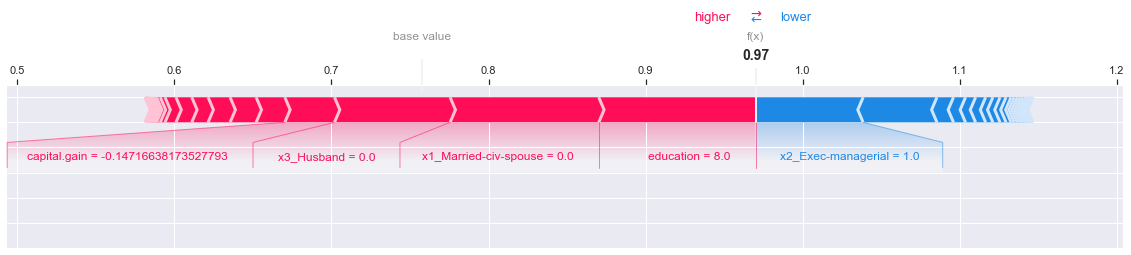

In [94]:
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0][11, :],
    X_train_sample.iloc[11, :],
    matplotlib=True,
)

Observations: 

- Everything is with respect to class 0 here. 
- The base value for class 0 is 0.758. 
- The score for class 0 is 0.95 and so the prediction is class 0 (<=50K). 
- We see the forces that drive the prediction. 
- Features that push the prediction to a higher value are shown in red. 
- Features that push the prediction to a lower value are shown in blue.
- For example, higher value for education (lower education) is pushing us towards <=50K income, whereas the categorical feature x2_Exec-managerial=1 is pushing us towards >50K income. 

Note: a nice thing about SHAP values is that the feature importances sum to the prediction:

In [38]:
shap_values[0][11].sum() + explainer.expected_value[0]

0.990000000137823

This is the same as `predict_proba` score for class 0! 

In [39]:
rf.predict_proba(X_train_sample)[11]

array([0.99, 0.01])

If we consider SHAP values for class 1, it'll be flipped. 

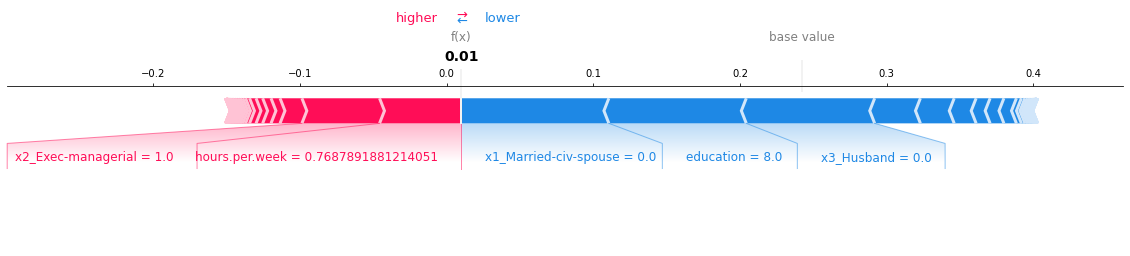

In [40]:
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][11, :],
    X_train_sample.iloc[11, :],
    matplotlib=True,
)

Above: for this particular training example, we can see the main factors pushing it from the base value (average over the dataset) to this particular prediction. 

Let's try it out on a test example. 
- We first need to get SHAP values for the test example. 
- Let's encode the test data. 

In [41]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test).toarray(),
    columns=feature_names,
    index=X_test.index,
)
X_test_enc.head()

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,education,sex,x0_Federal-gov,x0_Local-gov,x0_Never-worked,...,x4_Puerto-Rico,x4_Scotland,x4_South,x4_Taiwan,x4_Thailand,x4_Trinadad&Tobago,x4_United-States,x4_Vietnam,x4_Yugoslavia,x4_missing
14160,-0.701161,0.864418,-0.147166,-0.21768,-0.042081,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27048,-1.437140,2.379813,-0.147166,-0.21768,-2.069258,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28868,-0.774759,0.141915,-0.147166,-0.21768,-0.042081,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5667,-0.259573,-0.779189,-0.147166,-0.21768,0.363354,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7827,-1.363542,-1.291798,-0.147166,-0.21768,-0.852952,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
X_test_sample = X_test_enc.sample(200, random_state=2)

In [43]:
test_shap_values = explainer.shap_values(X_test_sample)

- What is `predict_proba` output for the first test example? 

In [70]:
rf.predict_proba(X_test_sample)[0]

array([0.92, 0.08])

Let's look at explanation for the prediction of 0.92. 

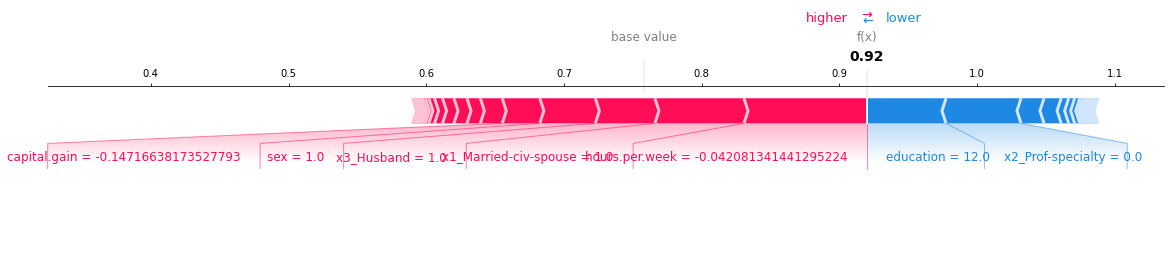

In [45]:
shap.force_plot(
    explainer.expected_value[0],
    test_shap_values[0][0, :],
    X_test_enc.iloc[0, :],
    matplotlib=True,
)

### Summary plot 

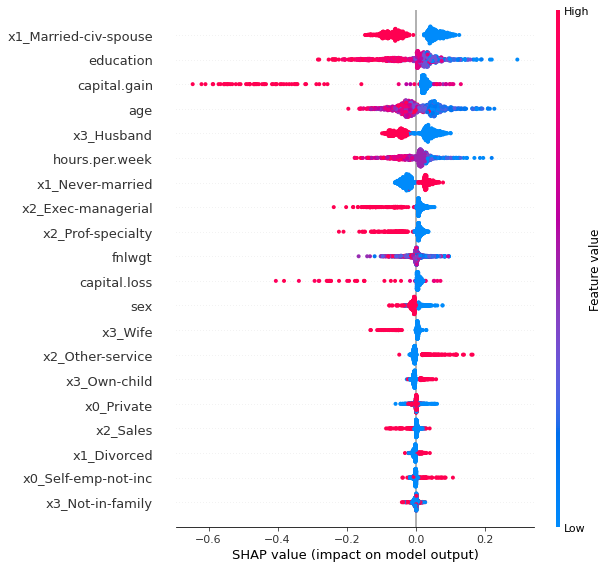

In [46]:
shap.summary_plot(shap_values[0], X_train_sample)

The plot shows the most important features for predicting the class. It also shows the direction of how it's going to drive the prediction.  

- In this case, x1_Married-civ-spouse seems like the most important feature on average.  
- Higher SHAP value means positive association with class 0 (<=50K class) in this case because we are using SHAP values for class 0. 
- Example: Smaller values of age seem to have positive association with class 0. 

### Dependence plot

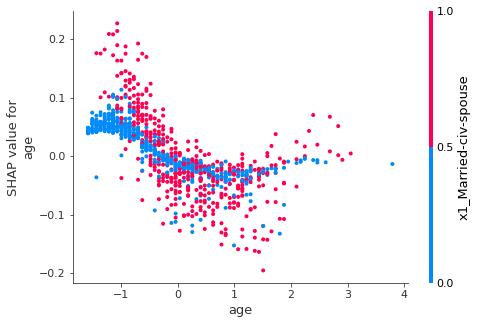

In [47]:
shap.dependence_plot("age", shap_values[0], X_train_sample)

The plot above shows effect of `age` feature on the prediction. 

- Each dot is a single prediction for 1000 examples above.
- The x-axis represents values of the feature age.
- The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. 
- Lower values of age have higher SHAP values for class "<=50K". 
- The color corresponds to a second feature (x1_Married-civ-spouse feature in this case) that may have an interaction effect with the feature we are plotting. 

Provides explainer for different kinds of models

- [TreeExplainer](https://shap.readthedocs.io/en/latest/) (supports XGBoost, CatBoost, LightGBM) 
- [DeepExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.DeepExplainer) (supports deep-learning models)
- [KernelExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.KernelExplainer) (supports kernel-based models)
- [GradientExplainer](https://shap.readthedocs.io/en/latest/index.html#shap.GradientExplainer) (supports Keras and Tensorflow models)


- Can also be used to explain text classification and image classification 
- Example: In the picture below, red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class. 

<img src="img/shap_image_explainer.png" width="600" height="600">

[Source](https://github.com/slundberg/shap)

### Other tools

- [lime](https://github.com/marcotcr/lime) is another package.

If you're not already impressed, keep in mind:

- So far we've only used sklearn models.
- Most sklearn models have some built-in measure of feature importances.
- On many tasks we need to move beyond sklearn, e.g. LightGBM, deep learning.
- These tools work on other models as well, which makes them extremely useful.

#### Why do we want this information?

Possible reasons:

- Identify features that are not useful and maybe remove them.
- Get guidance on what new data to collect.
  - New features related to useful features -> better results.
  - Don't bother collecting useless features -> save resources.
- Help explain why the model is making certain predictions. 
  - Debugging, if the model is behaving strangely.
  - Regulatory requirements.
  - Fairness / bias.
  - Keep in mind this can be use on **deployment** predictions!